(chap-pyabf)=
# Exploring records with `pyabf`

## Using External Python Packages 

We assume that the correct Python environment is already set up; see Section "{ref}`conda-virtual-set-up`" for details.

Let’s import the external libraries needed to work with the notebook:

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pyabf

print(f"numpy: {np.__version__}")
print(f"matplotlib: {matplotlib.__version__}")
print(f"seaborn: {sns.__version__}")
print(f"pyabf: {pyabf.__version__}")

numpy: 1.26.4
matplotlib: 3.8.4
seaborn: 0.12.2
pyabf: 2.3.8


## `pyABF` on the net

The  [pyABF](https://pypi.org/project/pyabf/) library was created by [Scott Harden](https://swharden.com/about/).
Scott Harden has made pyABF available as an open-source library, aiming to simplify the process of working with ABF files in Python, making it easier for researchers to analyze and visualize their data. You can find more about pyABF and its documentation on his website: 

- a (good) [tutorial](https://swharden.com/pyabf/tutorial/) by [Scott W Harden]
- [pyABF - A simple Python interface for Axon Binary Format ABF files](https://swharden.com/pyabf/), with [git repository](https://github.com/swharden/pyABF)
- in Python Package Index [pypi](https://pypi.org/project/pyabf/)


## Exploring `abf` files

This first notebook aims to demonstrate how to analyze electrophysiological recordings from a single cell by:

- Extracting basic characteristics of the recorded signals.
- Plotting, for each recording trial (sweep, see below), the evolution of the membrane potential (voltage) and, if applicable, the injected current.

We consider `abf` files contained in the data directory `data/data_patch_clamp_bcam/records`:

In [2]:
from pathlib import Path
records_dir = Path("data/data_patch_clamp_bcam/records")
abf_files = list(records_dir.rglob("*.abf")) # recursive glob
print("the directory ", records_dir, " contains ", len(abf_files)," abf files")

the directory  data/data_patch_clamp_bcam/records  contains  63  abf files


We focus on specific records:

In [3]:
file_path = "data/data_patch_clamp_bcam/records/2024_06/06.26/C2/2024_06_26_0028.abf"


### `abf` files and `pyabf` library

#### ABF File Overview

An ABF (Axon Binary Format) file is a proprietary file format developed by Axon Instruments (now part of Molecular Devices) to store electrophysiological data from experiments. ABF files are commonly used to save data from experiments like patch-clamp recordings, where researchers measure electrical signals from biological systems (such as neurons or muscle cells). These files can store a variety of information, including:

- Data Traces: Time series data for one or more channels, representing signals such as voltage or current.
- Metadata: Information about the experiment, including settings for the recording, such as sampling rate, experiment type, and device configuration.
- Multiple Sweeps: An ABF file can contain multiple sweeps (individual trials or experimental runs), which may differ in parameters or conditions.

The ABF format is binary, making it efficient for large datasets, but it is not easily readable without specialized software or libraries.

### `pyabf` Library

The `pyabf` library is a Python package designed to facilitate working with ABF files. It provides an easy-to-use interface to read and manipulate data stored in ABF files. The library makes it simpler for researchers to extract relevant information from ABF files, without having to manually parse the binary data.

Key Features of pyabf:

1.	Load ABF Files: Load an ABF file into memory and provide access to its data.
2.	Access Data Traces: Extract time-series data, such as voltage and current traces (from ADC channels).
3.	Multiple Sweep Support: Handle multiple sweeps (individual experimental runs) within a single ABF file.
4.	Extract Metadata: Retrieve metadata like channel names, experiment parameters, and other settings.
5.	Sweep Navigation: Select and navigate through multiple sweeps (trials) and analyze their data individually.

Common Functions in pyabf:

- `ABF(file_path)`: Initializes an ABF object from a given file path, loading the data into memory.
- `setSweep(sweep_index)`: Selects a specific sweep (experimental run) by its index.
- `sweepY`: Extracts the voltage (or other signal) data for the current sweep.
- `sweepX`: Extracts the time vector for the current sweep.
- `sweepC`: Extracts the command input (if available) for the current sweep.
- `adcNames`: List of ADC channel names.
- `dacNames`: List of DAC channel names.

### Basics about `abf` objects

Where we import the `pyabf` package and load a record file:

In [4]:
abf = pyabf.ABF(file_path)              # we load it
print(abf)                              # record characteristics 

ABF (v2.9) with 2 channels (mV, pA), sampled at 10.0 kHz, containing 14 sweeps, having no tags, with a total length of 2.35 minutes, recorded with protocol "IV-DG".


Here `abf = pyabf.ABF(file_path)` creates an `abf` object that have:
- **attributes**: data stored in the object, and
- **methods**: functions that belong to an object and can be called to perform actions

#### Atributes
We can print more attributes:

In [5]:
print(f"{'File Path:':>20} {abf.abfFilePath}")
print(f"{'File Version:':>20} {abf.abfVersionString}")
print(f"{'Sampling Rate:':>20} {abf.dataRate} Hz")
print(f"{'Total Sweeps:':>20} {abf.sweepCount}")
print(f"{'ADC Channels:':>20} {abf.adcNames}")
print(f"{'DAC Channels:':>20} {abf.dacNames}")
print(f"{'Channel Units:':>20} {abf.sweepUnitsY}")
print(f"{'Experiment Date:':>20} {abf.abfDateTime}")

          File Path: /Users/campillo/Documents/0-git.nosync/data-science-spikes/data/data_patch_clamp_bcam/records/2024_06/06.26/C2/2024_06_26_0028.abf
       File Version: 2.9.0.0
      Sampling Rate: 10000 Hz
       Total Sweeps: 14
       ADC Channels: ['IN 0', 'IN 1']
       DAC Channels: ['OUT 0', 'OUT 1']
      Channel Units: mV
    Experiment Date: 2024-06-26 17:23:16.253000


#### Methods

You can list all the methods of an `abf` object with `print(abf.__dict__)`.

In [6]:
methods = [method for method in dir(abf) if callable(getattr(abf, method)) and not method.startswith("__")]
print("\n".join(methods))

_dtype
_getAdcNameAndUnits
_getDacNameAndUnits
_ide_helper
_loadAndScaleData
_makeAdditionalVariables
_readHeadersV1
_readHeadersV2
getAllXs
getAllYs
headerLaunch
launchInClampFit
saveABF1
setSweep
sweepD


You have private methods (Prefixed with _), and:

- `getAllXs()`: Returns all time points (X-values) for every sweep, useful for plotting.
- `getAllYs()`: Returns all recorded signal values (Y-values) for every sweep.
- `headerLaunch()`: Likely a utility function for debugging or inspecting header information.
- `launchInClampFit()`: Opens the ABF file in ClampFit, a software from Molecular Devices used for electrophysiology data analysis.
- `saveABF1()`: Converts and saves the ABF file in version 1 format, which is older but sometimes required for compatibility.
- `setSweep(sweepIndex)`: Sets the current sweep (i.e., trial or recording segment) to a given index for further processing.
- `sweepD`: Likely an attribute or method that provides the time duration of a sweep.

Of course the main parts of the sweep are the **recorded signal** and the **command input**:

In [7]:
# Print voltage trace (recorded signal)
print(f"{'Voltage Trace (mV):':>25} {abf.sweepY}")

# Print command input (if available)
print(f"{'Command Input (mV):':>25} {abf.sweepC}")

      Voltage Trace (mV): [-65.4175 -65.4175 -65.4236 ... -64.6851 -64.6851 -64.6851]
      Command Input (mV): [0. 0. 0. ... 0. 0. 0.]


### Basic `abf` file exploration

#### Main `abf` attributes and methods

The `abf` object contains various attributes and methods that allow you to access metadata and data from the .abf file. Here are some useful attributes and how to call them:

In [8]:
print("List of sweep indexes:", ", ".join(map(str, abf.sweepList)))

List of sweep indexes: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13


In [9]:
sweep_index = 0  # Choose a specific sweep (e.g., first sweep -> index 0)
abf.setSweep(sweep_index)  

print(f"{'Voltage Trace (mV):':>25} {abf.sweepY}")  # Print voltage trace (recorded signal)
print(f"{'Command Input (mV):':>25} {abf.sweepC}")  # Print command input (if available)
print(f"{'Recorded Channels:':>25} {abf.adcNames}") # Check all available ADC channels (recorded signals)
print(f"{'Command Channels:':>25} {abf.dacNames}")  # Check DAC channels (command input signals)

      Voltage Trace (mV): [-65.4175 -65.4175 -65.4236 ... -64.6851 -64.6851 -64.6851]
      Command Input (mV): [0. 0. 0. ... 0. 0. 0.]
       Recorded Channels: ['IN 0', 'IN 1']
        Command Channels: ['OUT 0', 'OUT 1']


#### Some statistics of 1 sweep 

Here, we have selected `sweep_index = 0`, representing the first sweep in the ABF file. We then compute some basic statistics of the corresponding voltage trace, such as the mean, median, min, max, standard deviation, and range of the signal:

In [10]:
data = abf.sweepY  # The voltage trace for the specific swwep

stats = {
    "Mean (mV)": np.mean(data),
    "Median (mV)": np.median(data),
    "Min (mV)": np.min(data),
    "Max (mV)": np.max(data),
    "Std Dev (mV)": np.std(data),
    "Range (mV)": np.ptp(data),  # Max - Min
}

print("\nVoltage Trace Statistics:")
for key, value in stats.items():
    print(f"{key:>20}: {value:.3f}")


Voltage Trace Statistics:
           Mean (mV): -81.502
         Median (mV): -91.797
            Min (mV): -93.097
            Max (mV): -64.545
        Std Dev (mV): 12.916
          Range (mV): 28.552


## Plots

### Plotting the voltage trace distribution

In [11]:
%config InlineBackend.figure_format = 'retina'

this configuration, known as the inline backend, helps achieve a balance between good visual quality and manageable file size, see Section   {ref}`jupyter-backends`.

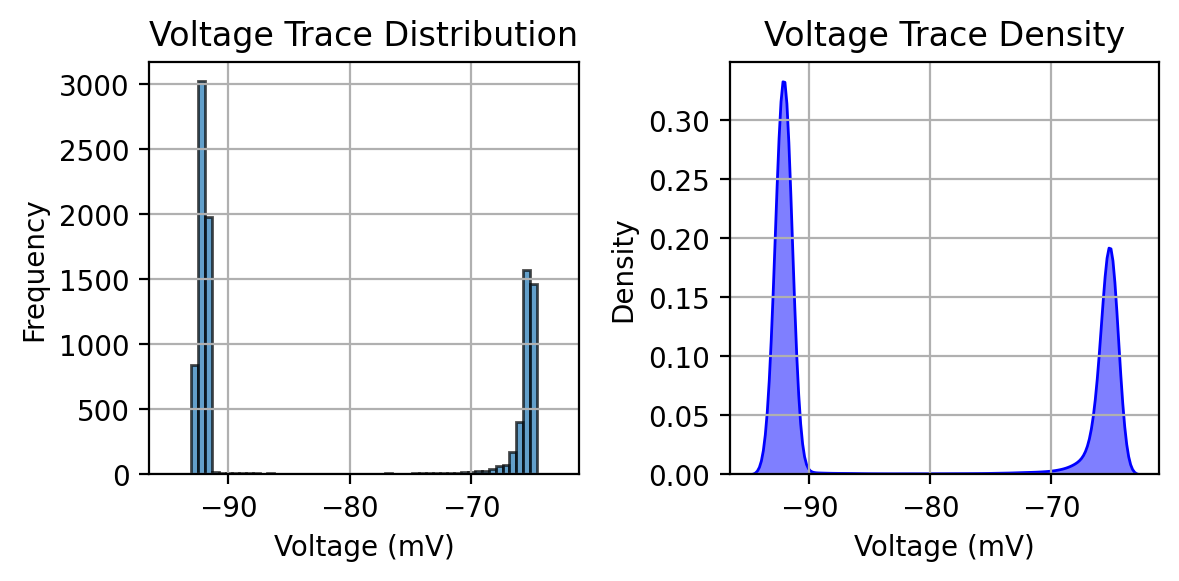

In [12]:
# to avoid warning from Seaborn internally calling a Pandas option 
# (mode.use_inf_as_na) that has been deprecated in pandas ≥ 2.1. 
import warnings  # needed for filterwarnings
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

mpl.rcParams['figure.figsize'] = (6, 3)

# Create a figure with two subplots (1 row, 2 columns), sharing x-axis
fig, axes = plt.subplots(1, 2, sharex=True)

# Plot histogram on the first subplot
axes[0].hist(data, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel("Voltage (mV)")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Voltage Trace Distribution")
axes[0].grid(True)

# Plot KDE on the second subplot
sns.kdeplot(data, bw_adjust=0.3, fill=True, color="b", alpha=0.5, ax=axes[1])
axes[1].set_xlabel("Voltage (mV)")
axes[1].set_ylabel("Density")
axes[1].set_title("Voltage Trace Density")
axes[1].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

### Plotting one sweep with input current

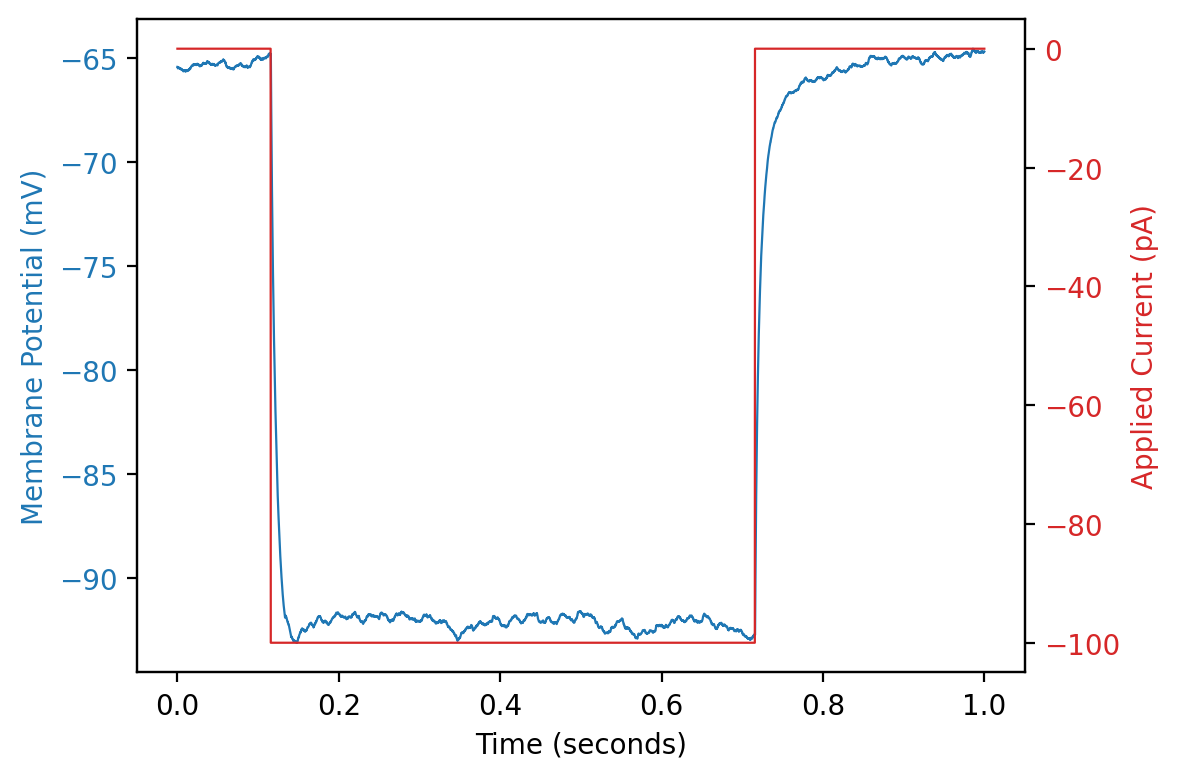

In [13]:
color_adc = "C0"
color_dac = "C3"
my_lw = 0.8

mpl.rcParams['figure.figsize'] = (6, 4)


# Create the figure
fig, ax1 = plt.subplots()

# Plot the recorded curve (ADC) on the left axis
ax1.plot(abf.sweepX, abf.sweepY, color=color_adc, lw=my_lw, label="ADC waveform")
ax1.set_xlabel(abf.sweepLabelX)
ax1.set_ylabel(abf.sweepLabelY, color=color_adc)
ax1.tick_params(axis='y', labelcolor=color_adc)

# Create a second y-axis for the control curve (DAC)
ax2 = ax1.twinx()
ax2.plot(abf.sweepX, abf.sweepC, color=color_dac, lw=my_lw,label="DAC waveform")
ax2.set_ylabel(abf.sweepLabelC, color=color_dac)
ax2.tick_params(axis='y', labelcolor=color_dac)

# Improve the layout
fig.tight_layout()
plt.show()

let put that last plotting in a function `plot_abf_sweep`

In [14]:
from utils.plots import plot_abf_sweep

help(plot_abf_sweep) # help/info for the function plot_abf_sweep

Help on function plot_abf_sweep in module utils.plots:

plot_abf_sweep(abf, sweep=0, color_adc='C0', color_dac='C3', lw=0.8)
    Plot a single sweep from an ABF file with ADC on the left y-axis
    and DAC on the right y-axis.
    
    Parameters:
    -----------
    abf : pyabf.ABF
        The ABF object.
    sweep : int
        Sweep number to plot (default 0).
    color_adc : str
        Color for the ADC waveform (default "C0").
    color_dac : str
        Color for the DAC waveform (default "C3").
    lw : float
        Line width (default 0.8).



`plot_abf_sweep?` gives the `Signature` of the function, so you can see the parameters and defaults, and the `Docstring` of the function (ie., everything inside the """ ... """ in the function)

### Plotting all sweeps

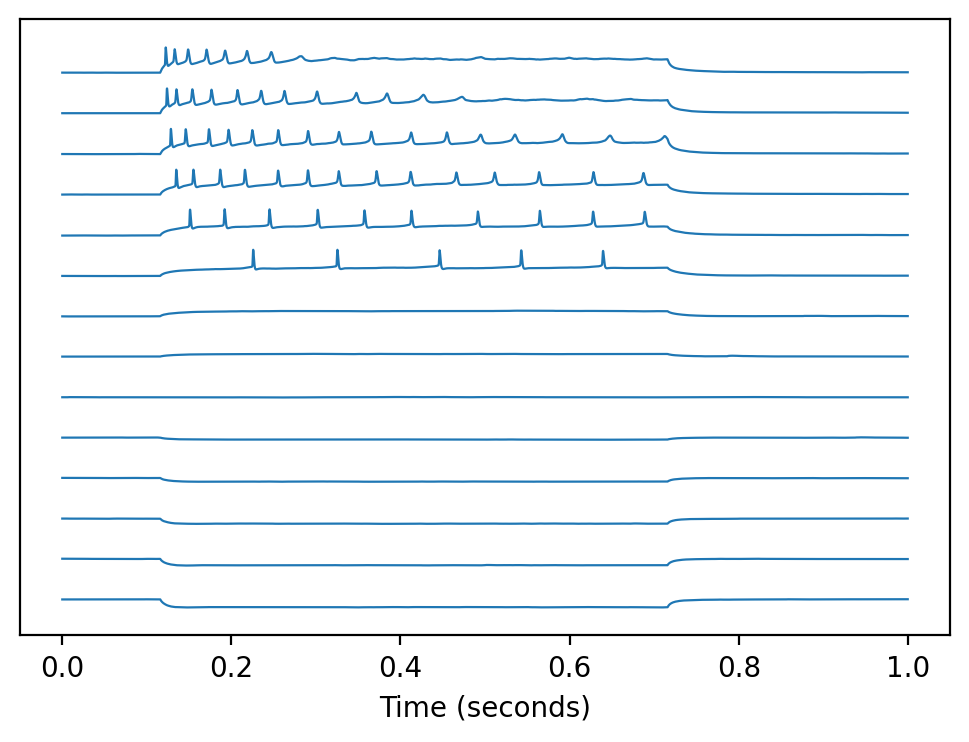

In [15]:
# plot every sweep (with vertical offset)
for sweepNumber in abf.sweepList:
    abf.setSweep(sweepNumber)
    offset = 140*sweepNumber
    plt.plot(abf.sweepX, abf.sweepY+offset, color=color_adc, lw=my_lw)

# decorate the plot
plt.gca().get_yaxis().set_visible(False)  # hide Y axis
plt.xlabel(abf.sweepLabelX)
plt.show()

### Plotting all sweeps with all inputs

We can improve the previous plot, see the python script `utils/plots.py`:

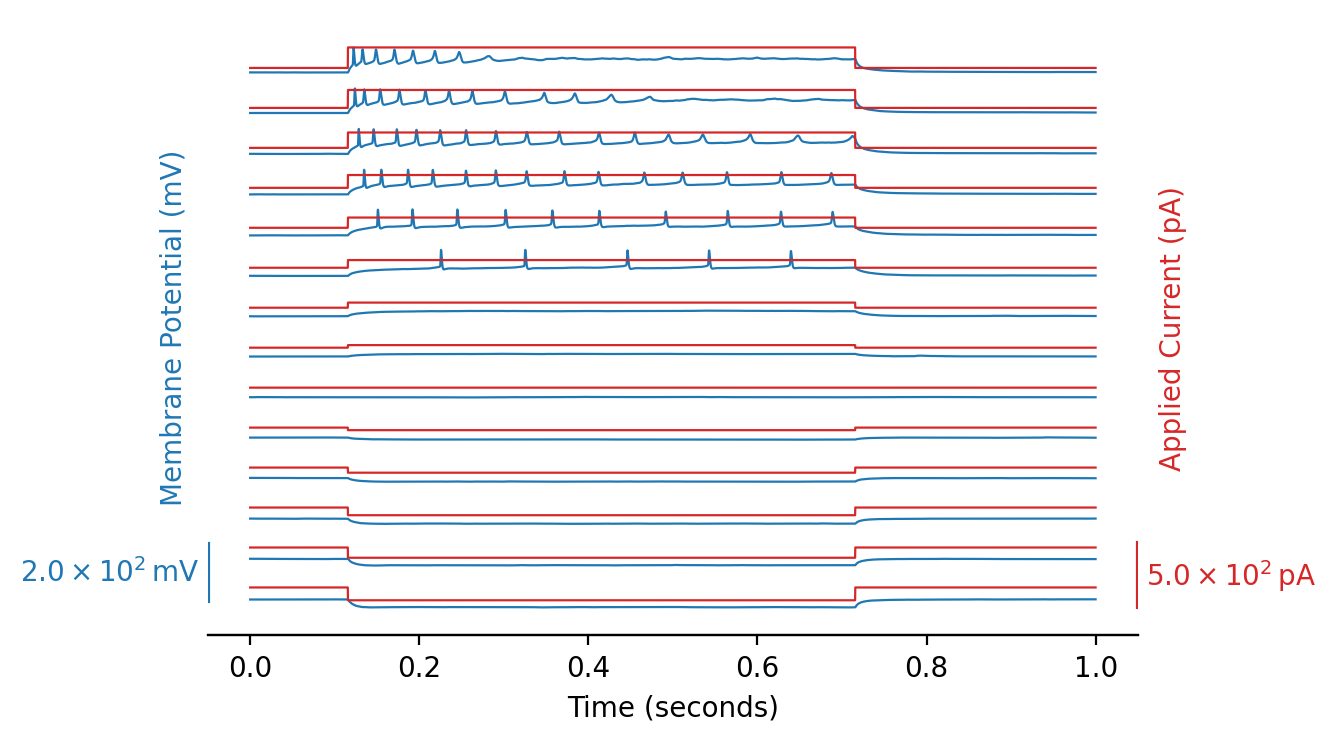

In [16]:
from utils.plots import plot_abf_traces_with_scalebar

fig, ax1, ax2 = plot_abf_traces_with_scalebar(abf)
plt.show()

Another possibility:

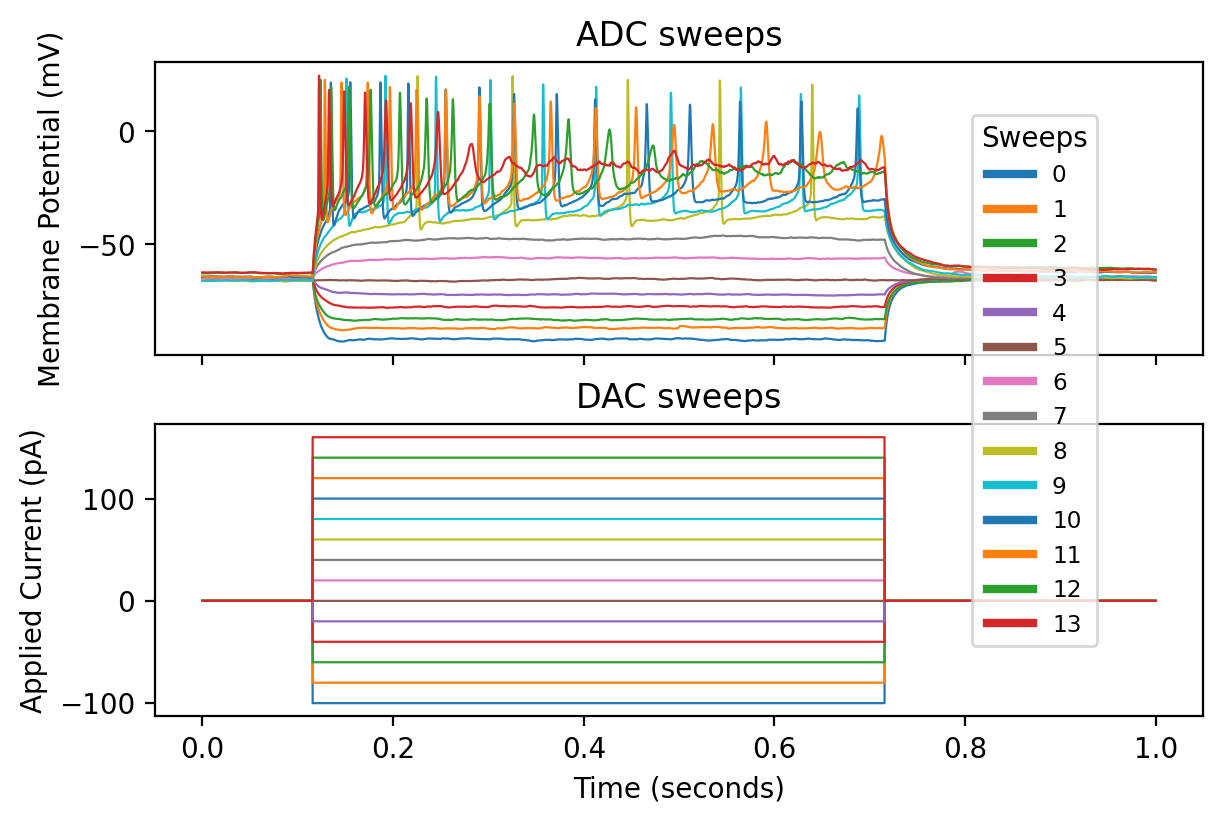

In [17]:
from utils.plots import plot_abf_sweeps_with_legend

fig, (ax1, ax2) = plot_abf_sweeps_with_legend(
    abf, legend_loc='upper left', legend_bbox=(0.8, 0.87), legend_pad=0
)
plt.show()